In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose
import cartopy
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import metpy.calc as mpcalc
import json
import calendar
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature 

import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import xarray as xr
from netCDF4 import num2date
import matplotlib.pyplot as plt


# ASAS: metodologia de SUN ET AL. (2017)

"In section 4 we analyze the climatological means and in-
terannual variability at the monthly time scale. The 850-hPa

geopotential height, rather than sea level pressure, is used to
depict the SASH to reduce complications from topography
over the adjacent continents. The analysis of interannual
variations in section 4b is based on detrended monthly data,
and the position of the high is determined as the location of

maximum 850-hPa geopotential height. Unlike the clima-
tological monthly averages, months from some years are

found to have multiple SASH centers (e.g., a western center
closer to South America and an eastern center near Africa),
indicating a positional shift of the anticyclone within the
month." Sun et al., 2017

In [4]:
hgtdata = xr.open_dataset('hgt.mon.mean.nc')
hgt = hgtdata.hgt

/home/lis/anaconda3/envs/bloqueios/lib/python3.8/site-packages/xarray/conventions.py:487: SerializationWarning: variable 'hgt' has multiple fill values {-32767, 32766}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [5]:
def suncoords(ds, periodos, level):
    lista = []
    #para cada valor de tempo i, o dataset do geopotencial é recortado para o level e as coordenadas do Oceano 
    #Atlântico. Posteriormente, o dataset resultante é filtrado para valores máximos do gepotencial em toda a 
    #região de recorte.
    for i, data in enumerate(pd.date_range(periodos[0], periodos[1], freq="MS", closed=None)):
        dado = ds.hgt.sel(lat=slice(0, -40)).sel(lon=slice(310, 360)).sel(level=level).sel(time=data).to_dataset()
        maximo = dado.where(dado==dado.max(), drop=True)
        lista.append(xr.DataArray(maximo.hgt, dims=['lat', 'lon'], coords={'lat': maximo.lat, 'level':level, 'lon': maximo.lon, 'time':maximo.time}, name = 'hgtmax'))
    saida = xr.concat(lista, dim='time').to_dataset()
    saida['methodology'] = "Sun et al. (2017)"
    saida['source'] = ds.source
    saida['range'] = str(periodos[0])[:4] + "-" + str(periodos[1])[:4]
    saida['description'] = "Maximum geopotential height values extracted from Atlantic Ocean region by month"
    return saida

In [1]:
def suncoords_clima(ds, periodos, level):
    month = np.arange(1, 13)
    lista=[]
    #primeiro, é realizado o recorte dos dados de geopotencial por período, coordenadas e nível. 
    #O recorte por período assume a diferença das coordenadas médias do ASAS para cada intervalo. 
    #Após o recorte, os dados são agrupados pela média mensal, como uma climatologia ou levantamento do período.
    dado = ds.hgt.sel(time=slice(periodos[0], periodos[1])).sel(level=level).sel(lat=slice(0, -40)).sel(lon=slice(310, 360)).groupby("time.month").mean()
    for i in month:
        dataset_OA = dado.sel(month=i).to_dataset()
        maximo = dataset_OA.where(dataset_OA==dataset_OA.max(), drop=True)
        lista.append(xr.DataArray(maximo.hgt, coords={'level':level, 'lat':maximo.lat, 'lon': maximo.lon, 'time':maximo.month}, name = 'hgtmax'))
    saida = xr.concat(lista, dim='time').to_dataset()
    saida['methodology'] = "Sun et al. (2017)"
    saida['source'] = ds.source
    saida['range'] = str(periodos[0])[:4] + "-" + str(periodos[1])[:4]
    saida['description'] = "Maximum geopotential height values extracted from Atlantic Ocean region by monthly long term means"
    return saida

In [76]:
def coords_scat(ax, j, sl, sl2=None, clima=None, clima2=None):
    
    handles = []
 
    for i in pd.to_datetime(sl.time.values):
        
        if i.month == j:

            bla = sl.sel(time=i)
            teste = bla.where(bla.hgtmax==bla.hgtmax.max(), drop=True)
            latitude = np.nanmax(teste.lat.data.tolist())
            longitude = np.mean(teste.lon.data.tolist())
            valores, xs, ys = teste.hgtmax, longitude, latitude         
            ax.scatter(xs, ys, transform=ccrs.PlateCarree(), color='darkcyan', alpha =0.5)
        cyan_patch = mpatches.Patch(color='darkcyan', label=str(pd.to_datetime(sl.time.values[0]).year) + " to " + str(pd.to_datetime(sl.time.values[-1]).year))
    handles.append(cyan_patch)
    
    
    if sl2 != None:
        for i in pd.to_datetime(sl2.time.values):
            if i.month == j:
                bla = sl2.sel(time=i)
                teste = bla.where(bla.hgtmax==bla.hgtmax.max(), drop=True)
                latitude = np.nanmax(teste.lat.data.tolist())
                longitude = np.mean(teste.lon.data.tolist())
                valores, xs, ys = teste.hgtmax, longitude, latitude 
                ax.scatter(xs, ys, transform=ccrs.PlateCarree(), color='orangered', alpha=0.4)
            red_patch = mpatches.Patch(color='orangered', label=str(pd.to_datetime(sl2.time.values[0]).year) + " to " + str(pd.to_datetime(sl2.time.values[-1]).year))
        handles.append(red_patch)
    
    if clima != None:
        for i in clima.time.values.tolist():
            if i == j:
                teste2 = clima.sel(time=i)
                gh = np.nanmax(teste2.hgtmax.values.tolist())
                latitude = np.nanmax(teste2.where(teste2.hgtmax==gh, drop=True).lat.values.tolist())
                longitude = np.nanmean(teste2.where(teste2.hgtmax==gh, drop=True).lon.values.tolist())
                xs, ys = longitude, latitude
                ax.scatter(xs, ys, s=500, transform=ccrs.PlateCarree(), color='darkcyan', alpha=0.8, marker='v')
            #black_patch = mpatches.Patch(color='black', label=str(pd.to_datetime(clima.time.values[0]).year) + " to " + str(pd.to_datetime(clima.time.values[-1]).year))
        #handles.append(black_patch)
        
    if clima2 != None:
        for i in clima2.time.values.tolist():
            if i == j:
                teste2 = clima2.sel(time=i)
                gh = np.nanmax(teste2.hgtmax.values.tolist())
                latitude = np.nanmax(teste2.where(teste2.hgtmax==gh, drop=True).lat.values.tolist())
                longitude = np.nanmean(teste2.where(teste2.hgtmax==gh, drop=True).lon.values.tolist())
                xs, ys = longitude, latitude
                ax.scatter(xs, ys, s=500, transform=ccrs.PlateCarree(), color='orangered', alpha=0.8, marker='v')
        #    white_patch = mpatches.Patch(color='white', label=str(pd.to_datetime(clima2.time.values[0]).year) + " to " + str(pd.to_datetime(clima2.time.values[-1]).year))
        #handles.append(white_patch)
        
    ax.legend(handles=handles, fontsize=15)
        
    ax.add_feature(cartopy.feature.LAND)
    ax.add_feature(cartopy.feature.OCEAN)
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':', edgecolor='gray')

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='black', alpha=0.3, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_left = True
    gl.ylabels_right = False
    gl.ylines = True
    gl.xlines = True
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 200, 10))
    gl.ylocator = mticker.FixedLocator(np.arange(-180, 200, 10))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 15}
    gl.ylabel_style = {'size': 15}

    ax.set_extent([310, 360, -31, -6])         
    ax.coastlines()
    ax.set_title(calendar.month_abbr[j], loc='left', fontsize=20)



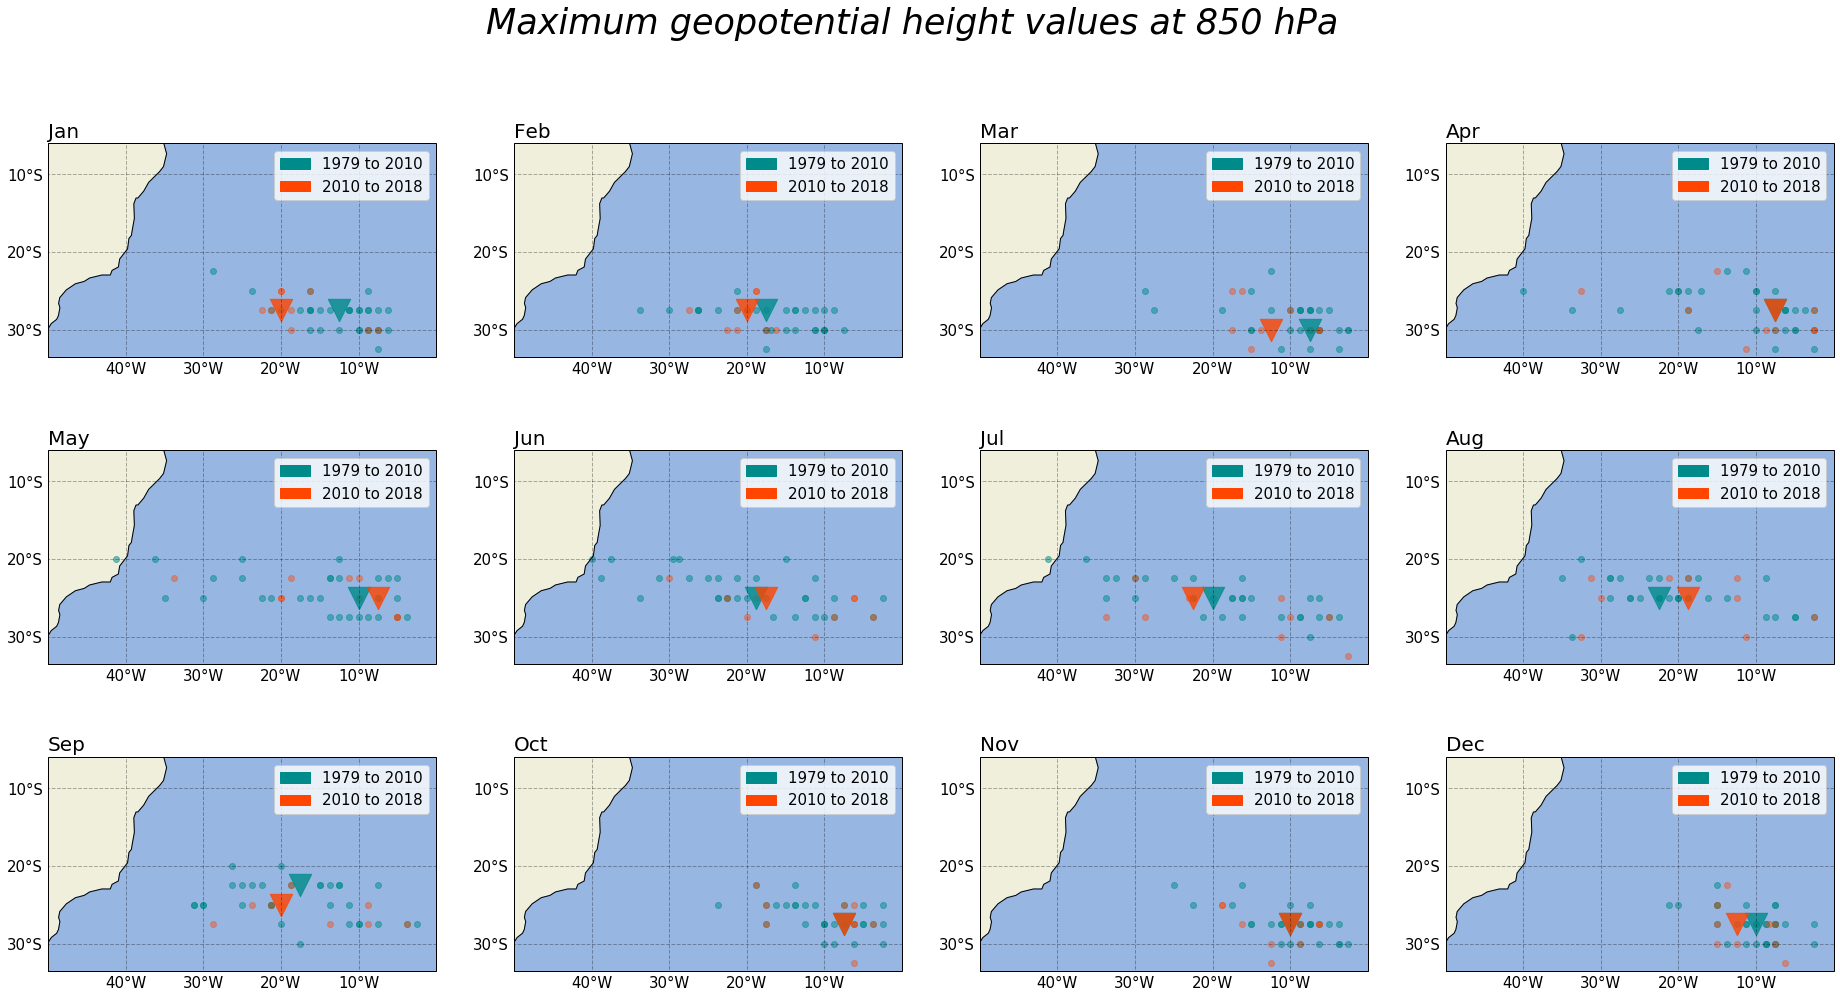

In [77]:
periodo = ["1979-01-01", "2010-01-01"]
periodo2 = ["2010-01-01", "2018-12-01"]
meses = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
fig, ax = plt.subplots(ncols = 4, nrows = 3, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(32, 16))
fig.suptitle("Maximum geopotential height values at " + str(level)+ " hPa", fontsize=35, fontstyle='italic')
coords_scat(ax[0,0], meses[0], suncoords(hgtdata, periodo, level), sl2=suncoords(hgtdata, periodo2, level), clima=suncoords_clima(hgtdata, periodo, level), clima2=suncoords_clima(hgtdata, periodo2, level))
coords_scat(ax[0,1], meses[1], suncoords(hgtdata, periodo, level), sl2=suncoords(hgtdata, periodo2, level), clima=suncoords_clima(hgtdata, periodo, level), clima2=suncoords_clima(hgtdata, periodo2, level))
coords_scat(ax[0,2], meses[2], suncoords(hgtdata, periodo, level), sl2=suncoords(hgtdata, periodo2, level), clima=suncoords_clima(hgtdata, periodo, level), clima2=suncoords_clima(hgtdata, periodo2, level))
coords_scat(ax[0,3], meses[3], suncoords(hgtdata, periodo, level), sl2=suncoords(hgtdata, periodo2, level), clima=suncoords_clima(hgtdata, periodo, level), clima2=suncoords_clima(hgtdata, periodo2, level))
coords_scat(ax[1,0], meses[4], suncoords(hgtdata, periodo, level), sl2=suncoords(hgtdata, periodo2, level), clima=suncoords_clima(hgtdata, periodo, level), clima2=suncoords_clima(hgtdata, periodo2, level))
coords_scat(ax[1,1], meses[5], suncoords(hgtdata, periodo, level), sl2=suncoords(hgtdata, periodo2, level), clima=suncoords_clima(hgtdata, periodo, level), clima2=suncoords_clima(hgtdata, periodo2, level))
coords_scat(ax[1,2], meses[6], suncoords(hgtdata, periodo, level), sl2=suncoords(hgtdata, periodo2, level), clima=suncoords_clima(hgtdata, periodo, level), clima2=suncoords_clima(hgtdata, periodo2, level))
coords_scat(ax[1,3], meses[7], suncoords(hgtdata, periodo, level), sl2=suncoords(hgtdata, periodo2, level), clima=suncoords_clima(hgtdata, periodo, level), clima2=suncoords_clima(hgtdata, periodo2, level))
coords_scat(ax[2,0], meses[8], suncoords(hgtdata, periodo, level), sl2=suncoords(hgtdata, periodo2, level), clima=suncoords_clima(hgtdata, periodo, level), clima2=suncoords_clima(hgtdata, periodo2, level))
coords_scat(ax[2,1], meses[9], suncoords(hgtdata, periodo, level), sl2=suncoords(hgtdata, periodo2, level), clima=suncoords_clima(hgtdata, periodo, level), clima2=suncoords_clima(hgtdata, periodo2, level))
coords_scat(ax[2,2], meses[10], suncoords(hgtdata, periodo, level), sl2=suncoords(hgtdata, periodo2, level), clima=suncoords_clima(hgtdata, periodo, level), clima2=suncoords_clima(hgtdata, periodo2, level))
coords_scat(ax[2,3], meses[11], suncoords(hgtdata, periodo, level), sl2=suncoords(hgtdata, periodo2, level), clima=suncoords_clima(hgtdata, periodo, level), clima2=suncoords_clima(hgtdata, periodo2, level))

plt.savefig('teste.png')

# ASAS: metodologia de REBOITA (2019)

"the SASA spatial configuration in hourly and daily MSLP fields can be disrupted due to the influence of transient
systems (...) that can show higher pressure than this semi-permanent system. Gilliland and Keim (2018a) observed
that the transient anticyclones are subject to be included in the dataset when the SASA position is identified using
daily data. This shows that climatology obtained with daily data may have inconsistencies. As the presented facts
can hinder the identification of the highest pressure position (core) of the SASA (Pezza and Ambrizzi, 2005),
we used monthly data, which is similar to the methodology employed by Mächel et al. (1998)

In order to find the highest pressure position of the SASA (core), we used an algorithm developed by the first author
of the persent study, which was previously used by Degola (2013). This algorithm uses the nearest neighbor technique
(...) This methodology was applied to the MLSP monthly data in the area of 40S-20S e 42W-12E. Some details of the
algorithm are: (a) one grid point is a candidate to be the SASA core if its MSLP is higher or equal than that of the 
first 8 neighboring points and higher than the other 40 points around; (b) in the case that more than one grid point
presents the same maximum pressure value, the grid point that presents the lowest latitude is considered the SASA
center"
(Reboita, 2019)

In [78]:
mslpdata = xr.open_dataset('pres.sfc.mon.mean.nc')
mslp = mslpdata.pres

In [79]:
def rcoords(ds, periodos):
    lista = []
    #para cada valor de tempo i, o dataset do geopotencial é recortado para o level e as coordenadas do Oceano 
    #Atlântico. Posteriormente, o dataset resultante é filtrado para valores máximos do gepotencial em toda a 
    #região de recorte.
    east = ds.sel(lon=slice(0, 12))
    west = ds.sel(lon=slice(318, 360))
    west['lon'] = west.lon - 360
    merged = xr.merge([east, west])
    for i, data in enumerate(pd.date_range(periodos[0], periodos[1], freq="MS", closed=None)):
        dado = merged.pres.sel(lat=slice(-20, -40)).sel(time=data).to_dataset()
        maximo = dado.where(dado==dado.max(), drop=True)
        lista.append(xr.DataArray(maximo.pres, dims=['lat', 'lon'], coords={'lat': maximo.lat, 'level':level, 'lon': maximo.lon, 'time':maximo.time}, name = 'sfcpresmax'))
    saida = xr.concat(lista, dim='time').to_dataset()
    saida['methodology'] = "Reboita et al. (2019)"
    saida['source'] = ds.source
    saida['range'] = str(periodos[0])[:4] + "-" + str(periodos[1])[:4]
    saida['description'] = "Maximum surface pressure values extracted from -20S to -40S; 318E to 12E region by month"
    return saida

In [96]:
sl = rcoords(mslpdata, periodo)

In [100]:
for i in pd.to_datetime(sl.time.values):

    if i.month == 1:

        bla = sl.sel(time=i)
        teste = bla.where(bla.sfcpresmax==bla.sfcpresmax.max(), drop=True)
        print(teste)
        latitude = np.nanmax(teste.lat.data.tolist())
        longitude = np.mean(teste.lon.data.tolist())

<xarray.Dataset>
Dimensions:      (lat: 1, lon: 1)
Coordinates:
    level        int64 850
  * lon          (lon) float64 10.0
  * lat          (lat) float64 -25.0
    time         datetime64[ns] 1979-01-01
Data variables:
    sfcpresmax   (lat, lon) float32 102230.0
    methodology  (lat, lon) object 'Reboita et al. (2019)'
    source       (lat, lon) object 'NCEP/DOE AMIP-II Reanalysis (Reanalysis-2) Model'
    range        (lat, lon) object '1979-2010'
    description  (lat, lon) object 'Maximum surface pressure values extracted from -20S to -40S; 318E to 12E region by month'
<xarray.Dataset>
Dimensions:      (lat: 1, lon: 1)
Coordinates:
    level        int64 850
  * lon          (lon) float64 10.0
  * lat          (lat) float64 -25.0
    time         datetime64[ns] 1980-01-01
Data variables:
    sfcpresmax   (lat, lon) float32 102370.0
    methodology  (lat, lon) object 'Reboita et al. (2019)'
    source       (lat, lon) object 'NCEP/DOE AMIP-II Reanalysis (Reanalysis-2) Model'
 

In [92]:
def mslpcoords_scat(ax, j, sl, sl2=None, clima=None, clima2=None):
    
    handles = []
 
    for i in pd.to_datetime(sl.time.values):
        
        if i.month == j:

            bla = sl.sel(time=i)
            teste = bla.where(bla.sfcpresmax==bla.sfcpresmax.max(), drop=True)
            latitude = np.nanmax(teste.lat.data.tolist())
            longitude = np.mean(teste.lon.data.tolist())
            valores, xs, ys = teste.sfcpresmax, longitude, latitude         
            ax.scatter(xs, ys, transform=ccrs.PlateCarree(), color='darkcyan', alpha =0.5)
        cyan_patch = mpatches.Patch(color='darkcyan', label=str(pd.to_datetime(sl.time.values[0]).year) + " to " + str(pd.to_datetime(sl.time.values[-1]).year))
    handles.append(cyan_patch)
    
    
    if sl2 != None:
        for i in pd.to_datetime(sl2.time.values):
            if i.month == j:
                bla = sl2.sel(time=i)
                teste = bla.where(bla.sfcpresmax==bla.sfcpresmax.max(), drop=True)
                latitude = np.nanmax(teste.lat.data.tolist())
                longitude = np.mean(teste.lon.data.tolist())
                valores, xs, ys = teste.sfcpresmax, longitude, latitude 
                ax.scatter(xs, ys, transform=ccrs.PlateCarree(), color='orangered', alpha=0.4)
            red_patch = mpatches.Patch(color='orangered', label=str(pd.to_datetime(sl2.time.values[0]).year) + " to " + str(pd.to_datetime(sl2.time.values[-1]).year))
        handles.append(red_patch)
    
    if clima != None:
        for i in clima.time.values.tolist():
            if i == j:
                teste2 = clima.sel(time=i)
                gh = np.nanmax(teste2.sfcpresmax.values.tolist())
                latitude = np.nanmax(teste2.where(teste2.sfcpresmax==gh, drop=True).lat.values.tolist())
                longitude = np.nanmean(teste2.where(teste2.sfcpresmax==gh, drop=True).lon.values.tolist())
                xs, ys = longitude, latitude
                ax.scatter(xs, ys, s=500, transform=ccrs.PlateCarree(), color='darkcyan', alpha=0.8, marker='v')
            #black_patch = mpatches.Patch(color='black', label=str(pd.to_datetime(clima.time.values[0]).year) + " to " + str(pd.to_datetime(clima.time.values[-1]).year))
        #handles.append(black_patch)
        
    if clima2 != None:
        for i in clima2.time.values.tolist():
            if i == j:
                teste2 = clima2.sel(time=i)
                gh = np.nanmax(teste2.sfcpresmax.values.tolist())
                latitude = np.nanmax(teste2.where(teste2.sfcpresmax==gh, drop=True).lat.values.tolist())
                longitude = np.nanmean(teste2.where(teste2.sfcpresmax==gh, drop=True).lon.values.tolist())
                xs, ys = longitude, latitude
                ax.scatter(xs, ys, s=500, transform=ccrs.PlateCarree(), color='orangered', alpha=0.8, marker='v')
        #    white_patch = mpatches.Patch(color='white', label=str(pd.to_datetime(clima2.time.values[0]).year) + " to " + str(pd.to_datetime(clima2.time.values[-1]).year))
        #handles.append(white_patch)
        
    ax.legend(handles=handles, fontsize=15)
        
    ax.add_feature(cartopy.feature.LAND)
    ax.add_feature(cartopy.feature.OCEAN)
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':', edgecolor='gray')

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='black', alpha=0.3, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_left = True
    gl.ylabels_right = False
    gl.ylines = True
    gl.xlines = True
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 200, 10))
    gl.ylocator = mticker.FixedLocator(np.arange(-180, 200, 10))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 15}
    gl.ylabel_style = {'size': 15}

    ax.set_extent([320, 375, -40, -15])         
    ax.coastlines()
    ax.set_title(calendar.month_abbr[j], loc='left', fontsize=20)



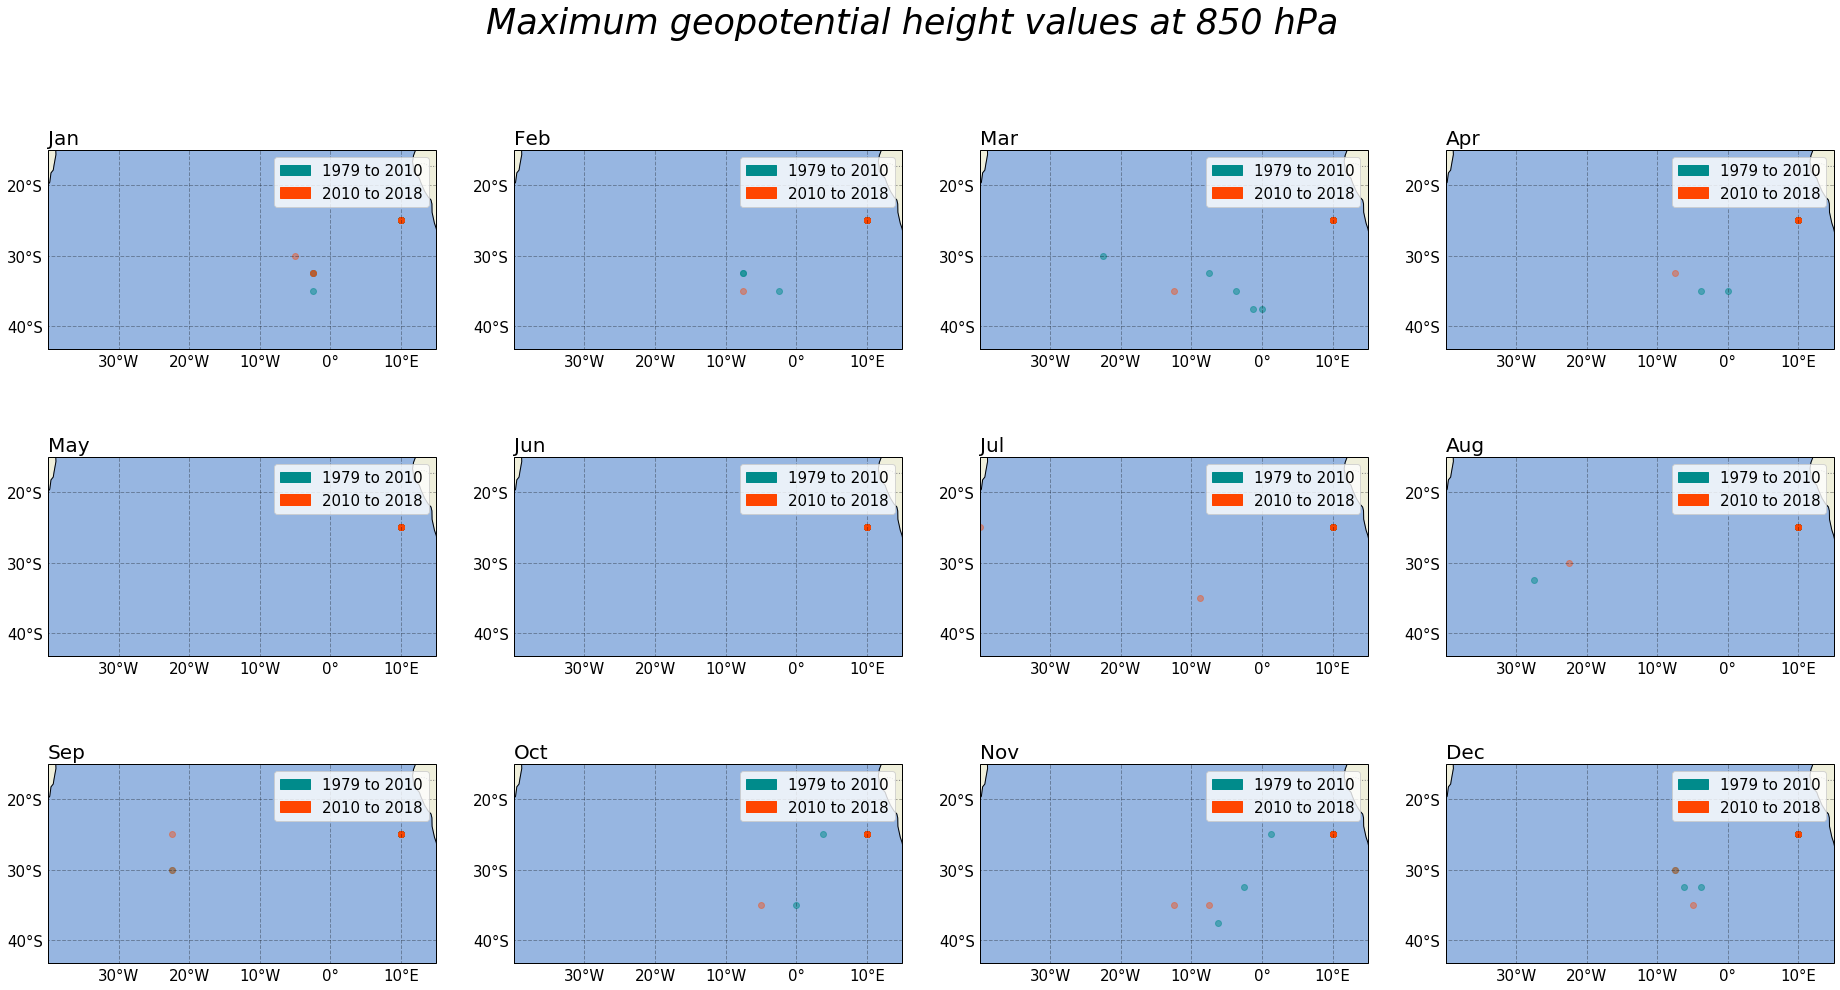

In [93]:
periodo = ["1979-01-01", "2010-01-01"]
periodo2 = ["2010-01-01", "2018-12-01"]
meses = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
fig, ax = plt.subplots(ncols = 4, nrows = 3, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(32, 16))
fig.suptitle("Maximum geopotential height values at " + str(level)+ " hPa", fontsize=35, fontstyle='italic')
mslpcoords_scat(ax[0,0], meses[0], rcoords(mslpdata, periodo), sl2=rcoords(mslpdata, periodo2))
mslpcoords_scat(ax[0,1], meses[1], rcoords(mslpdata, periodo), sl2=rcoords(mslpdata, periodo2))
mslpcoords_scat(ax[0,2], meses[2], rcoords(mslpdata, periodo), sl2=rcoords(mslpdata, periodo2))
mslpcoords_scat(ax[0,3], meses[3], rcoords(mslpdata, periodo), sl2=rcoords(mslpdata, periodo2))
mslpcoords_scat(ax[1,0], meses[4], rcoords(mslpdata, periodo), sl2=rcoords(mslpdata, periodo2))
mslpcoords_scat(ax[1,1], meses[5], rcoords(mslpdata, periodo), sl2=rcoords(mslpdata, periodo2))
mslpcoords_scat(ax[1,2], meses[6], rcoords(mslpdata, periodo), sl2=rcoords(mslpdata, periodo2))
mslpcoords_scat(ax[1,3], meses[7], rcoords(mslpdata, periodo), sl2=rcoords(mslpdata, periodo2))
mslpcoords_scat(ax[2,0], meses[8], rcoords(mslpdata, periodo), sl2=rcoords(mslpdata, periodo2))
mslpcoords_scat(ax[2,1], meses[9], rcoords(mslpdata, periodo), sl2=rcoords(mslpdata, periodo2))
mslpcoords_scat(ax[2,2], meses[10], rcoords(mslpdata, periodo), sl2=rcoords(mslpdata, periodo2))
mslpcoords_scat(ax[2,3], meses[11], rcoords(mslpdata, periodo), sl2=rcoords(mslpdata, periodo2))

#plt.savefig('teste.png')